In [19]:
import numpy as np , math , time , os
from skimage import io
from CarDetection_HOG import display, readimg, get_hist_grid , Block_Normalization, Block_Normalization_Preprocess
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  
from skimage.transform import resize
n_imgs = 16000
n_win = 64
n_cell = 8
n_block = 1
n_sml_hist = 18
hists_per_dim =(n_win-n_cell*n_block)//n_cell+1 
n_hist = hists_per_dim * hists_per_dim*n_sml_hist*n_block*n_block
test_ratio = 0.2
thres = 10
img_scales = [1, 0.8, 0.6]

In [2]:
t = time.time()

x = np.zeros((n_imgs,n_hist*3) , dtype=np.float)
y = np.zeros((n_imgs) , dtype=np.float)

vehicles_data_path = os.getcwd() + '\\data\\Vehicles\\'
non_vehicles_data_path = os.getcwd() + '\\data\\Non-Vehicles\\'

img_index = 1
#Reading Vehicles & Non-Vehicles images:
for i in range(0 , n_imgs//2 , 2):
    #img = io.imread(vehicles_data_path + "v_ (" + str(img_index) + ").png")
    img = readimg(vehicles_data_path + "v_ (" + str(img_index) + ").png")
    #img = resize(img, (n_win, n_win), anti_aliasing=True)
    #x[i,:] = Block_Normalization(get_hist_grid(img , n_cell))
    get_hist_grid(img)
    Block_Normalization_Preprocess()
    x[i,:] = Block_Normalization(0,0)
    y[i] = 1.0
    
    #img = io.imread(non_vehicles_data_path + "nv_ (" + str(img_index) + ").png")
    img = readimg(non_vehicles_data_path + "nv_ (" + str(img_index) + ").png")
    #img = resize(img, (n_win, n_win), anti_aliasing=True)
    #x[i+1,:] = Block_Normalization(get_hist_grid(img , n_cell))
    get_hist_grid(img)
    Block_Normalization_Preprocess()
    x[i+1,:] = Block_Normalization(0,0)
    y[i+1] = 0.0
    
    img_index += 1
    
print("Train and test images reading and features extraction time: " , time.time()-t)

Train and test images reading and features extraction time:  491.98572182655334


In [3]:
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = test_ratio)
clf = SVC(kernel='linear')
t0 = time.time()
clf.fit(x_train , y_train)
t1 = time.time()
print("Training Time: " , t1-t0)

t2 = time.time()
p = clf.predict(x_test)
t3 = time.time()
print("Prediction Time: " , t3-t2)
print('Prediction ', p)
print('Accuracy ' , accuracy_score(y_test , p))

Training Time:  42.13432192802429
Prediction Time:  9.834653377532959
Prediction  [0. 1. 0. ... 1. 1. 0.]
Accuracy  0.9984375


In [4]:
def Classify(img):
    res = clf.predict(img)
    return res[0]

In [5]:
def Crop_Image(img, deno):
    return img[img.shape[0]//deno : img.shape[0]]

In [11]:
def Slide_Window(img , window_size , step, r, c, ratio):
    h = img.shape[0] - window_size + 1
    w = img.shape[1] - window_size + 1
    
    R,C = img.shape[0] , img.shape[1]
    mat = np.zeros((r,c) , dtype = np.byte)
    window = np.zeros((1,n_hist*3) , dtype=np.float)
    #i = -1
    get_hist_grid(img)
    Block_Normalization_Preprocess()
    
    for I in range(0 , R , step):
        if(R-I >= window_size):
            #i += 1
            #j = 0
            for J in range(0 , C , step):
                if(C-J >= window_size):
                    #window[0,:] = Block_Normalization(get_hist_grid(img[I : I+window_size , J : J+window_size] , n_cell))
                    window[0,:] = Block_Normalization(I, J)
                    mat[int(round(I*ratio))][int(round(J*ratio))] = Classify(window)
                    
                    #j += 1
        
                else:
                    break
        else:
            break
                              
    return mat

In [12]:
def get_heatmap(img, win_width, step):
    r, c = img.shape[0], img.shape[1]
    img_scales_len = len(img_scales)
    fin_pxl_mat = np.zeros((r, c), dtype=int)
    for k in range(img_scales_len):
        r_new, c_new = int(round(r*img_scales[k])), int(round(c*img_scales[k]))
        print('Calculating heatmap of scale: '+str(r_new)+', '+str(c_new))
        resz_img = resize(img, (r_new, c_new), anti_aliasing=True)
        ratio = 1.0/img_scales[k]
        win_mat=Slide_Window(resz_img, win_width, step, r, c, ratio)
        for i in range(r-win_width+1):
            for j in range(1, c-win_width+1):
                win_mat[i,j]+=win_mat[i,j-1]
        for j in range(c-win_width+1):
            for i in range(1, r-win_width+1):
                win_mat[i,j]+=win_mat[i-1,j]
        pxl_mat = np.zeros((r, c), dtype=int)
        resz_win_width = int(round(win_width*ratio))
        for i in range(r):
            for j in range(c):
                tl_i, tl_j = max(i-resz_win_width+1, 0), max(j-resz_win_width+1, 0)
                br_i, br_j = min(i+resz_win_width-1, r-1), min(j+resz_win_width-1, c-1)
                br_i, br_j = br_i-resz_win_width+1, br_j-resz_win_width+1
                sum = win_mat[br_i, br_j]
                if(tl_i-1>=0):
                    sum -= win_mat[tl_i-1, br_j]
                if(tl_j-1>=0):
                    sum -= win_mat[br_i, tl_j-1]
                if(tl_i-1>=0 and tl_j-1>=0):
                    sum += win_mat[tl_i-1, tl_j-1]
                if(sum < thres):
                    sum = 0
                pxl_mat[i, j] = sum
        fin_pxl_mat += pxl_mat
    return fin_pxl_mat

In [20]:
t4 = time.time()
im = readimg('x.jpeg')
im = Crop_Image(im, 4)
im = resize(im, (512, 1024), anti_aliasing=True)
print(im.shape)
qt = get_heatmap(im , n_win, n_cell)
t5 = time.time()
print("Image reading and Heatmap generation Time: ", t5-t4)
#print(qt)

C:\Users\lenovo\AppData\Roaming\Python\Python36\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(512, 1024, 3)
Calculating heatmap of scale: 512, 1024
Calculating heatmap of scale: 410, 819
Calculating heatmap of scale: 307, 614
Image reading and Heatmap generation Time:  67.00585198402405


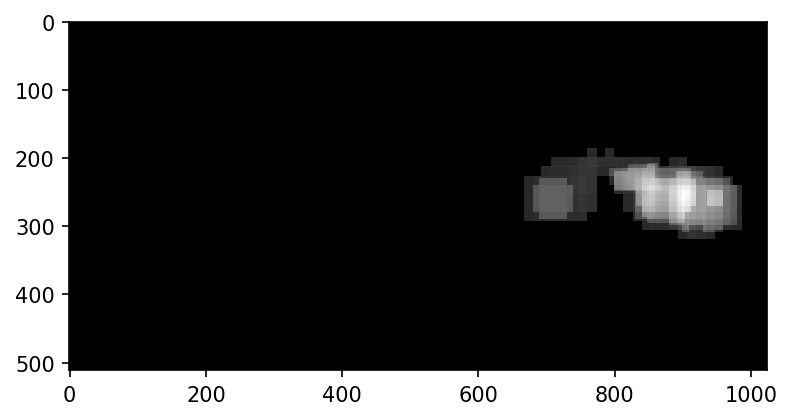

In [21]:
display(qt, True)

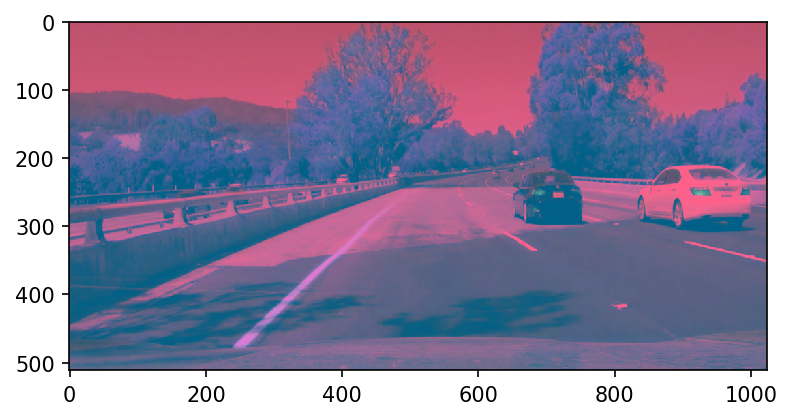

In [22]:
display(im, False)